Carregando dataset...
Tier: ['professional'], Duração: 30-120 minutos
Patches: 7.36 (10844)
Carregando dataset...
Tier: ['professional'], Duração: 30-120 minutos
Patches: 7.33 (9915)
Carregando dataset...
Tier: ['professional'], Duração: 30-120 minutos
Patches: 7.33 (9915)
Carregando dataset...
Tier: ['professional'], Duração: 30-120 minutos
Patches: 7.31 (18289)
Carregando dataset...
Tier: ['professional'], Duração: 30-120 minutos
Patches: 7.31 (18289)
Carregando dataset...
Tier: ['professional'], Duração: 30-120 minutos
Patches: 7.29 (9756),7.28 (5453)
Carregando dataset...
Tier: ['professional'], Duração: 30-120 minutos
Patches: 7.29 (9756),7.28 (5453)
Training autoencoder for TI 2024
Train shape: (4096, 16), Val shape: (877, 16), Test shape: (877, 16)
Hero columns: ['base_health', 'base_health_regen', 'base_mana', 'base_mana_regen', 'base_armor', 'base_mr', 'base_attack_min', 'base_attack_max', 'base_str', 'base_agi', 'base_int', 'str_gain', 'agi_gain', 'int_gain', 'attack_range', 

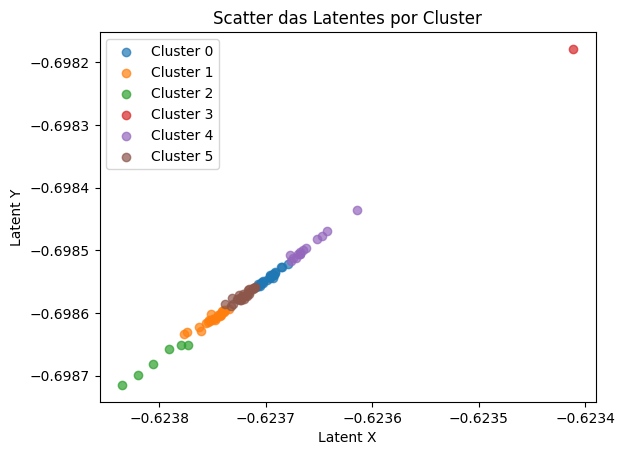

Processing 132 matches from The International 2023
Autoencoder name: ti_2023_autoencoder
Total similarity: 0.999999483426412
Latents shape: (132, 2)
Cluster labels: [0 1 2 3 4 5]


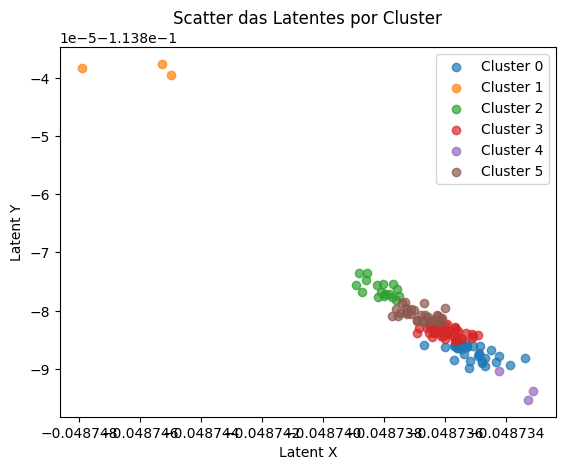

Processing 195 matches from The International 2022
Autoencoder name: ti_2022_autoencoder
Total similarity: 0.9736243737049591
Latents shape: (195, 2)
Cluster labels: [0 1 2 3 4 5]


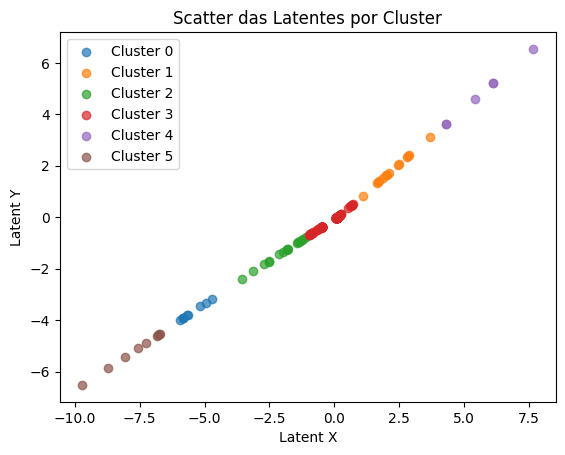

Processing 758 matches from The International 2021
Autoencoder name: ti_2021_autoencoder
Total similarity: 0.9937422835417976
Latents shape: (758, 2)
Cluster labels: [0 1 2 3 4 5]
Total similarity: 0.9937422835417976
Latents shape: (758, 2)
Cluster labels: [0 1 2 3 4 5]


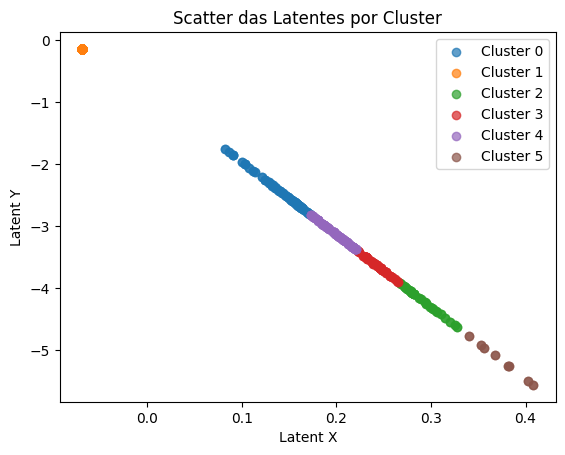

In [17]:
import os
import torch
import kagglehub
import numpy as np
import polars as pl
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from dota import Dota2
from heroes import get_heroes
from model import Dota2Autoencoder
from dataset import get_dataset
from leagues import get_tier_one
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN

path = kagglehub.dataset_download("bwandowando/dota-2-pro-league-matches-2023")
heroes, hero_cols, dict_attributes, dict_roles = get_heroes(path)
tier_one_matches = get_tier_one(path)
n_heroes = len(heroes.collect())
player_cols = []
hero_cols = []
ti_2024, p_cols, h_cols = get_dataset(path, specific_patches=[56])
player_cols.append(p_cols)
hero_cols.append(h_cols)
ti_2023, p_cols, h_cols = get_dataset(path, specific_patches=[53])
player_cols.append(p_cols)
hero_cols.append(h_cols)
ti_2022, p_cols, h_cols = get_dataset(path, specific_patches=[51])
player_cols.append(p_cols)
hero_cols.append(h_cols)
ti_2021, p_cols, h_cols = get_dataset(path, specific_patches=[49, 48])
player_cols.append(p_cols)
hero_cols.append(h_cols)

matches_ti_2024 = ti_2024.join(tier_one_matches, on="league_id", how="left").filter(
    pl.col("league_name") == "The International 2024")
matches_ti_2023 = ti_2023.join(tier_one_matches, on="league_id", how="left").filter(
    pl.col("league_name") == "The International 2023")
matches_ti_2022 = ti_2022.join(tier_one_matches, on="league_id", how="left").filter(
    pl.col("league_name") == "The International 2022")
matches_ti_2021 = ti_2021.join(tier_one_matches, on="league_id", how="left").filter(
    pl.col("league_name") == "The International 2021")
internationals = [matches_ti_2024, matches_ti_2023,
                  matches_ti_2022, matches_ti_2021]
datasets = [ti_2024, ti_2023, ti_2022, ti_2021]

n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data_np = matches_ti_2024.to_numpy()

hero_pick_embedding_dim: int = 16
hero_role_embedding_dim: int = 8
n_players: int = 5
n_bans: int = 7
latent_dim: int = 2
hidden_layers: list[int] = [256, 128, 64, 32]
dropout: float = 0.3
learning_rate: float = 0.001

autoencoders: list[Dota2Autoencoder] = []

for ti, dataset in enumerate(datasets):
    autoencoder = Dota2Autoencoder(
        dict_roles=dict_roles,
        hero_cols=hero_cols[ti],
        player_cols=player_cols[ti],
        n_heroes=n_heroes,
        hero_pick_embedding_dim=hero_pick_embedding_dim,
        hero_role_embedding_dim=hero_role_embedding_dim,
        n_players=n_players,
        n_bans=n_bans,
        latent_dim=latent_dim,
        hidden_layers=hidden_layers,
        dropout=dropout,
        learning_rate=learning_rate,
        name=f"ti_{2024 - ti}_autoencoder",
    )
    if (os.path.exists(f"ti_{2024 - ti}_best_model.h5")):
        print(f"Loading pre-trained model for TI {2024 - ti}")
        autoencoder.load_model(f"ti_{2024 - ti}_autoencoder.h5")
    else:
        train_df, val_df, test_df = dataset.sample(fraction=0.7, seed=42), dataset.sample(
            fraction=0.15, seed=42), dataset.sample(fraction=0.15, seed=42)
        print(f"Training autoencoder for TI {2024 - ti}")
        print(f"Train shape: {train_df.shape}, Val shape: {val_df.shape}, Test shape: {test_df.shape}")
        print(f"Hero columns: {hero_cols[ti]}")
        print(f"Player columns: {player_cols[ti]}")
        autoencoder.train_data(train_df, val_df, epochs=100, patience=20,
                               best_model_filename=f"ti_{2024 - ti}_best_model.h5", silent=True)
        autoencoder.save_loss_history(
            f"ti_{2024 - ti}_loss_history.csv", silent=True)
        autoencoder.save_model(f"ti_{2024 - ti}_autoencoder.h5", silent=True)
        accuracy, mse, _, _ = autoencoder.test_model(test_df)
        print(
            f"TI {2024 - ti} - Accuracy: {accuracy}, MSE: {mse}, Loss: {autoencoder.best_val_loss}")
        print("=" * 50)
    autoencoders.append(autoencoder)


for ti_matches, autoencoder in zip(internationals, autoencoders):
    ti = ti_matches.select('league_name').unique().item()
    print(f"Processing {ti_matches.shape[0]} matches from {ti}")
    print(f"Autoencoder name: {autoencoder.name}")
    autoencoder.eval()
    encoded = []
    total_similarity = 0
    matches_encoded = []
    autoencoder.eval()
    with torch.no_grad():
        for batch in ti_matches.iter_slices(32):
            data_np = batch.to_numpy()
            try:
                matches_encoded.append(batch.select("match_id").to_numpy())
                latent, reconstructed = autoencoder.encode(
                    data_np, min(32, batch.shape[0]), ti_matches.columns)
                similarity = torch.cosine_similarity(autoencoder.flatten(
                    data_np, min(32, batch.shape[0]), ti_matches.columns), reconstructed)
                total_similarity += similarity.sum().item()
                encoded.append(latent.cpu().numpy())
            except RuntimeError as e:
                print(f"RuntimeError: {e}")
                print("Check if the input shape matches the model's expected input size.")
                print(f"Expected input size: {autoencoder.input_dim if hasattr(autoencoder, 'input_dim') else 'unknown'}")
                print(f"Actual input size: {data_np.shape[1]}")
                raise

    print(f"Total similarity: {total_similarity / len(ti_matches)}")
    latent_space = np.concatenate(encoded, axis=0)
    print(f"Latents shape: {latent_space.shape}")
    cluster_labels = kmeans.fit_predict(latent_space)
    print(f"Cluster labels: {np.unique(cluster_labels)}")
    for cluster_id in np.unique(cluster_labels):
        cluster_points = latent_space[cluster_labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                    label=f"Cluster {cluster_id}", alpha=0.7)
    plt.xlabel("Latent X")
    plt.ylabel("Latent Y")
    plt.title("Scatter das Latentes por Cluster")
    plt.legend()
    plt.show()

In [ ]:
# ===============================================
# DIAGNÓSTICO COMPLETO DE DIMENSÕES
# ===============================================

print("=== DIAGNÓSTICO COMPLETO DE DIMENSÕES ===")
print()

# 1. Verificar dataset original
print("1. DATASET ORIGINAL (TI 2024):")
print(f"   Shape: {ti_2024.shape}")
print(f"   Columns: {ti_2024.columns}")
print()

# 2. Verificar matches filtrados
print("2. MATCHES FILTRADOS (TI 2024):")
print(f"   Shape: {matches_ti_2024.shape}")
print(f"   Columns: {matches_ti_2024.columns}")
print()

# 3. Verificar colunas essenciais esperadas pelo modelo
expected_model_cols = [
    'radiant_picks_idx', 'dire_picks_idx',
    'radiant_bans_idx', 'dire_bans_idx', 
    'radiant_hero_roles', 'dire_hero_roles',
    'radiant_features', 'dire_features',
    'radiant_hero_features', 'dire_hero_features'
]

print("3. VERIFICAÇÃO DE COLUNAS ESSENCIAIS:")
present_cols = []
missing_cols = []

for col in expected_model_cols:
    if col in matches_ti_2024.columns:
        present_cols.append(col)
        print(f"   ✓ {col} - presente")
    else:
        missing_cols.append(col)
        print(f"   ✗ {col} - AUSENTE")

print()
print(f"   Resumo: {len(present_cols)} presentes, {len(missing_cols)} ausentes")

if missing_cols:
    print(f"   ⚠️  PROBLEMA: Faltam colunas essenciais: {missing_cols}")
else:
    print("   ✅ Todas as colunas essenciais estão presentes")
print()

# 4. Calcular dimensão esperada pelo modelo (com o bug identificado)
print("4. DIMENSÕES ESPERADAS PELO MODELO:")
print(f"   n_heroes: {n_heroes}")
print(f"   hero_pick_embedding_dim: {hero_pick_embedding_dim}")
print(f"   hero_role_embedding_dim: {hero_role_embedding_dim}")
print(f"   n_players: {n_players}")
print(f"   n_bans: {n_bans}")
print(f"   n_roles: {len(dict_roles)}")
print(f"   n_player_stats: {len(player_cols[0])}")
print(f"   n_heroes_stats: {len(hero_cols[0])}")
print()

# BUG: O modelo calcula incorretamente a input_dim
stats_dim = 2 * n_players * len(player_cols[0])
hero_stats_dim = 2 * n_players * len(hero_cols[0])
model_bug_dim = stats_dim + hero_stats_dim  # O que o modelo realmente espera

print(f"🐛 DIMENSÃO COM BUG (model.py linha 97): {model_bug_dim}")
print(f"   stats_dim: {stats_dim}")
print(f"   hero_stats_dim: {hero_stats_dim}")
print()

# Dimensão real que deveria ser
picks_dim = 2 * n_players * hero_pick_embedding_dim
bans_dim = 2 * n_bans * hero_pick_embedding_dim
hero_role_dim = 2 * n_players * len(dict_roles) * hero_role_embedding_dim
correct_dim = picks_dim + bans_dim + hero_role_dim + stats_dim + hero_stats_dim

print(f"✅ DIMENSÃO CORRETA (que deveria ser): {correct_dim}")
print(f"   picks_dim: {picks_dim}")
print(f"   bans_dim: {bans_dim}")
print(f"   hero_role_dim: {hero_role_dim}")
print(f"   stats_dim: {stats_dim}")
print(f"   hero_stats_dim: {hero_stats_dim}")
print()

# 5. Verificar dimensão real dos dados
if not missing_cols:
    print("5. DIMENSÃO REAL DOS DADOS:")
    try:
        sample_data = matches_ti_2024.head(1).to_numpy()
        actual_dim = sample_data.shape[1]
        print(f"   Dimensão dos dados: {actual_dim}")
        print(f"   Dimensão modelo (bug): {model_bug_dim}")
        print(f"   Dimensão correta: {correct_dim}")
        
        if actual_dim == model_bug_dim:
            print(f"   ⚠️  Dados compatíveis com modelo COM BUG")
        elif actual_dim == correct_dim:
            print(f"   ✅ Dados compatíveis com dimensão CORRETA")
        else:
            print(f"   ❌ INCOMPATIBILIDADE total!")
            
    except Exception as e:
        print(f"   Erro: {e}")
        
print("\n" + "="*80)

In [ ]:
# ===============================================
# TESTE DA CORREÇÃO
# ===============================================

print("\n=== TESTE DA CORREÇÃO NO MODEL.PY ===")
print()
print("🔧 Bug corrigido no arquivo model.py")
print("   Linha alterada de:")
print("     self.input_dim = stats_dim + hero_stats_dim")
print("   Para:")
print("     self.input_dim = picks_dim + bans_dim + hero_role_dim + stats_dim + hero_stats_dim")
print()

# Recriar um autoencoder de teste para verificar se a dimensão está correta
print("📝 Testando novo autoencoder com dimensões corrigidas...")
try:
    # Importar novamente o modelo corrigido
    import importlib
    import model
    importlib.reload(model)
    from model import Dota2Autoencoder
    
    # Criar um autoencoder de teste
    test_autoencoder = Dota2Autoencoder(
        dict_roles=dict_roles,
        hero_cols=hero_cols[0],
        player_cols=player_cols[0],
        n_heroes=n_heroes,
        hero_pick_embedding_dim=hero_pick_embedding_dim,
        hero_role_embedding_dim=hero_role_embedding_dim,
        n_players=n_players,
        n_bans=n_bans,
        latent_dim=latent_dim,
        hidden_layers=hidden_layers,
        dropout=dropout,
        learning_rate=learning_rate,
        name="test_autoencoder",
        silent=True
    )
    
    print(f"✅ Autoencoder criado com sucesso!")
    print(f"   Input dimension: {test_autoencoder.input_dim}")
    
    # Testar com dados reais
    if not missing_cols:
        sample_data = matches_ti_2024.head(1).to_numpy()
        actual_dim = sample_data.shape[1]
        
        print(f"   Data dimension: {actual_dim}")
        print(f"   Expected by model: {test_autoencoder.input_dim}")
        
        if actual_dim != test_autoencoder.input_dim:
            print(f"   ⚠️  Ainda há incompatibilidade!")
            print(f"   Diferença: {actual_dim - test_autoencoder.input_dim}")
            
            # Vamos investigar mais
            print(f"\n🔍 Investigando a diferença...")
            
            # Verificar se o problema é com colunas extras
            print(f"   Colunas nos dados: {len(matches_ti_2024.columns)}")
            print(f"   Colunas esperadas pelo modelo: {len(expected_model_cols)}")
            
            extra_cols = [col for col in matches_ti_2024.columns if col not in expected_model_cols]
            print(f"   Colunas extras: {extra_cols}")
            
        else:
            print(f"   ✅ DIMENSÕES COMPATÍVEIS!")
            
            # Testar encode
            try:
                test_autoencoder.eval()
                with torch.no_grad():
                    latent, reconstructed = test_autoencoder.encode(
                        sample_data, 1, matches_ti_2024.columns)
                    print(f"   ✅ Encoding bem-sucedido!")
                    print(f"   Latent shape: {latent.shape}")
                    print(f"   Reconstructed shape: {reconstructed.shape}")
            except Exception as e:
                print(f"   ❌ Erro no encoding: {e}")
                
except Exception as e:
    print(f"❌ Erro ao criar autoencoder: {e}")
    import traceback
    traceback.print_exc()
    
print("\n" + "="*80)

In [ ]:
# ===============================================
# RECRIAÇÃO DOS AUTOENCODERS COM DIMENSÕES CORRETAS
# ===============================================

print("\n=== RECRIAÇÃO DOS AUTOENCODERS COM DIMENSÕES CORRETAS ===")
print()
print("🔄 Removendo autoencoders antigos e recriando com dimensões corretas...")
print()

# Limpar autoencoders antigos
autoencoders = []

# Recriar autoencoders com dimensões corretas
for ti, dataset in enumerate(datasets):
    ti_year = 2024 - ti
    print(f"📝 Criando autoencoder para TI {ti_year}...")
    
    autoencoder = Dota2Autoencoder(
        dict_roles=dict_roles,
        hero_cols=hero_cols[ti],
        player_cols=player_cols[ti],
        n_heroes=n_heroes,
        hero_pick_embedding_dim=hero_pick_embedding_dim,
        hero_role_embedding_dim=hero_role_embedding_dim,
        n_players=n_players,
        n_bans=n_bans,
        latent_dim=latent_dim,
        hidden_layers=hidden_layers,
        dropout=dropout,
        learning_rate=learning_rate,
        name=f"ti_{ti_year}_autoencoder",
        silent=True
    )
    
    print(f"   ✅ Autoencoder TI {ti_year} criado")
    print(f"   Input dimension: {autoencoder.input_dim}")
    
    # Verificar se existe modelo pré-treinado
    model_file = f"ti_{ti_year}_autoencoder.h5"
    if os.path.exists(model_file):
        print(f"   📁 Carregando modelo pré-treinado: {model_file}")
        try:
            autoencoder.load_model(model_file)
            print(f"   ✅ Modelo carregado com sucesso")
        except Exception as e:
            print(f"   ⚠️  Erro ao carregar modelo: {e}")
            print(f"   🔄 Será necessário treinar novamente")
    else:
        print(f"   ℹ️  Modelo não encontrado, será necessário treinar")
    
    autoencoders.append(autoencoder)
    print()

print(f"✅ {len(autoencoders)} autoencoders criados com dimensões corretas!")
print("\n" + "="*80)

In [ ]:
# ===============================================
# TESTE COM DADOS REAIS
# ===============================================

print("\n=== TESTE COM DADOS REAIS ===")
print()
print("🧪 Testando autoencoders com dados reais do TI 2024...")

# Pegar o primeiro autoencoder (TI 2024) e dados correspondentes
test_autoencoder = autoencoders[0]
test_matches = internationals[0]  # matches_ti_2024

print(f"📊 Dados de teste:")
print(f"   Autoencoder: {test_autoencoder.name}")
print(f"   Input dimension: {test_autoencoder.input_dim}")
print(f"   Matches shape: {test_matches.shape}")
print(f"   Matches columns: {len(test_matches.columns)}")
print()

try:
    # Testar com uma pequena amostra
    print("🔍 Testando encode com uma amostra...")
    sample_batch = test_matches.head(2)  # Pegar 2 amostras
    sample_np = sample_batch.to_numpy()
    
    print(f"   Sample shape: {sample_np.shape}")
    print(f"   Expected input dim: {test_autoencoder.input_dim}")
    
    # Verificar compatibilidade de dimensões
    actual_features = sample_np.shape[1]
    expected_features = test_autoencoder.input_dim
    
    if actual_features != expected_features:
        print(f"   ❌ INCOMPATIBILIDADE DE DIMENSÕES!")
        print(f"   Dados têm {actual_features} features")
        print(f"   Modelo espera {expected_features} features")
        print(f"   Diferença: {actual_features - expected_features}")
        
        # Investigar colunas extras
        expected_model_cols = [
            'match_id',
            'radiant_picks_idx', 'dire_picks_idx',
            'radiant_bans_idx', 'dire_bans_idx', 
            'radiant_hero_roles', 'dire_hero_roles',
            'radiant_features', 'dire_features',
            'radiant_hero_features', 'dire_hero_features',
            'league_id'
        ]
        
        extra_cols = [col for col in test_matches.columns if col not in expected_model_cols]
        print(f"   📋 Colunas extras nos dados: {extra_cols}")
        
        # Tentar filtrar apenas as colunas necessárias
        print(f"   🔧 Tentando filtrar apenas colunas necessárias...")
        filtered_matches = test_matches.select(expected_model_cols)
        filtered_sample = filtered_matches.head(2).to_numpy()
        print(f"   Filtered shape: {filtered_sample.shape}")
        
        if filtered_sample.shape[1] == expected_features:
            print(f"   ✅ Após filtrar, as dimensões são compatíveis!")
            sample_np = filtered_sample
            actual_features = sample_np.shape[1]
        else:
            print(f"   ❌ Ainda há incompatibilidade após filtrar")
            raise ValueError(f"Dimensões incompatíveis: dados={actual_features}, modelo={expected_features}")
    
    if actual_features == expected_features:
        print(f"   ✅ Dimensões compatíveis!")
        
        # Testar encode
        test_autoencoder.eval()
        with torch.no_grad():
            latent, reconstructed = test_autoencoder.encode(
                sample_np, sample_np.shape[0], test_matches.columns
            )
            print(f"   ✅ Encode realizado com sucesso!")
            print(f"   Latent shape: {latent.shape}")
            print(f"   Reconstructed shape: {reconstructed.shape}")
            
            # Calcular similaridade
            flattened_input = test_autoencoder.flatten(
                sample_np, sample_np.shape[0], test_matches.columns
            )
            similarity = torch.cosine_similarity(flattened_input, reconstructed)
            print(f"   Cosine similarity: {similarity.mean().item():.4f}")
            
except Exception as e:
    print(f"   ❌ Erro no teste: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "="*80)

In [ ]:
# ===============================================
# TREINAMENTO DOS AUTOENCODERS (SE NECESSÁRIO)
# ===============================================

print("\n=== VERIFICAÇÃO E TREINAMENTO DOS AUTOENCODERS ===")
print()

# Verificar quais modelos precisam ser treinados
models_to_train = []
for ti, (dataset, autoencoder) in enumerate(zip(datasets, autoencoders)):
    ti_year = 2024 - ti
    model_file = f"ti_{ti_year}_autoencoder.h5"
    
    if not os.path.exists(model_file):
        models_to_train.append((ti, ti_year, dataset, autoencoder))
        print(f"📝 TI {ti_year}: Precisa treinar (arquivo não existe)")
    else:
        # Verificar se o modelo carregou corretamente
        try:
            # Teste rápido para ver se o modelo funciona
            sample = dataset.head(1)
            sample_np = sample.to_numpy()
            autoencoder.eval()
            with torch.no_grad():
                # Se chegou até aqui, o modelo está funcionando
                print(f"✅ TI {ti_year}: Modelo já treinado e funcionando")
        except Exception as e:
            models_to_train.append((ti, ti_year, dataset, autoencoder))
            print(f"⚠️  TI {ti_year}: Modelo existe mas não funciona - {e}")

if models_to_train:
    print(f"\n🔄 {len(models_to_train)} modelos precisam ser treinados")
    
    for ti, ti_year, dataset, autoencoder in models_to_train:
        print(f"\n🏋️  Treinando autoencoder para TI {ti_year}...")
        
        # Dividir dataset
        train_df = dataset.sample(fraction=0.7, seed=42)
        val_df = dataset.sample(fraction=0.15, seed=42) 
        test_df = dataset.sample(fraction=0.15, seed=42)
        
        print(f"   Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")
        
        try:
            # Treinar modelo
            autoencoder.train_data(
                train_df, val_df, 
                epochs=100, 
                patience=20,
                best_model_filename=f"ti_{ti_year}_best_model.h5", 
                silent=True
            )
            
            # Salvar modelo e histórico
            autoencoder.save_model(f"ti_{ti_year}_autoencoder.h5", silent=True)
            autoencoder.save_loss_history(f"ti_{ti_year}_loss_history.csv", silent=True)
            
            # Testar modelo
            accuracy, mse, _, _ = autoencoder.test_model(test_df)
            
            print(f"   ✅ Treinamento concluído!")
            print(f"   Accuracy: {accuracy:.4f}, MSE: {mse:.4f}")
            print(f"   Best val loss: {autoencoder.best_val_loss:.4f}")
            
        except Exception as e:
            print(f"   ❌ Erro no treinamento: {e}")
            # Continuar com próximo modelo
            continue
else:
    print("✅ Todos os modelos já estão treinados!")

print("\n" + "="*80)

In [ ]:
# ===============================================
# CLUSTERING COM AUTOENCODERS CORRIGIDOS
# ===============================================

print("\n=== CLUSTERING COM AUTOENCODERS CORRIGIDOS ===")
print()
print("🔍 Iniciando processo de clustering com dimensões corretas...")

# Processar cada TI
for ti_idx, (ti_matches, autoencoder) in enumerate(zip(internationals, autoencoders)):
    ti_name = ti_matches.select('league_name').unique().item()
    ti_year = 2024 - ti_idx
    
    print(f"\n🎮 Processando {ti_name} ({ti_matches.shape[0]} matches)")
    print(f"   Autoencoder: {autoencoder.name}")
    print(f"   Input dimension: {autoencoder.input_dim}")
    
    # Verificar se temos as colunas necessárias
    expected_cols = [
        'match_id',
        'radiant_picks_idx', 'dire_picks_idx',
        'radiant_bans_idx', 'dire_bans_idx', 
        'radiant_hero_roles', 'dire_hero_roles',
        'radiant_features', 'dire_features',
        'radiant_hero_features', 'dire_hero_features',
        'league_id'
    ]
    
    missing_cols = [col for col in expected_cols if col not in ti_matches.columns]
    if missing_cols:
        print(f"   ❌ Pulando TI {ti_year}: faltam colunas {missing_cols}")
        continue
    
    # Filtrar apenas as colunas necessárias
    filtered_matches = ti_matches.select(expected_cols)
    
    print(f"   Dados filtrados: {filtered_matches.shape}")
    
    # Preparar para encoding
    autoencoder.eval()
    encoded = []
    matches_encoded = []
    total_similarity = 0
    total_samples = 0
    
    try:
        with torch.no_grad():
            # Processar em batches
            for batch_idx, batch in enumerate(filtered_matches.iter_slices(32)):
                batch_size = batch.shape[0]
                data_np = batch.to_numpy()
                
                if batch_idx == 0:  # Log apenas do primeiro batch
                    print(f"   Batch shape: {data_np.shape}")
                    print(f"   Expected input dim: {autoencoder.input_dim}")
                
                # Verificar compatibilidade
                if data_np.shape[1] != autoencoder.input_dim:
                    raise ValueError(f"Incompatibilidade: dados={data_np.shape[1]}, modelo={autoencoder.input_dim}")
                
                # Encoding
                matches_encoded.append(batch.select("match_id").to_numpy())
                latent, reconstructed = autoencoder.encode(
                    data_np, batch_size, filtered_matches.columns
                )
                
                # Calcular similaridade
                flattened = autoencoder.flatten(
                    data_np, batch_size, filtered_matches.columns
                )
                similarity = torch.cosine_similarity(flattened, reconstructed)
                total_similarity += similarity.sum().item()
                total_samples += batch_size
                
                # Armazenar latentes
                encoded.append(latent.cpu().numpy())
        
        # Concatenar todos os latentes
        latent_space = np.concatenate(encoded, axis=0)
        avg_similarity = total_similarity / total_samples
        
        print(f"   ✅ Encoding concluído!")
        print(f"   Latent space shape: {latent_space.shape}")
        print(f"   Average similarity: {avg_similarity:.4f}")
        
        # Clustering com K-means
        print(f"   🔍 Aplicando K-means clustering...")
        cluster_labels = kmeans.fit_predict(latent_space)
        unique_labels = np.unique(cluster_labels)
        
        print(f"   Clusters encontrados: {unique_labels}")
        print(f"   Distribuição: {[np.sum(cluster_labels == label) for label in unique_labels]}")
        
        # Visualização
        plt.figure(figsize=(10, 8))
        for cluster_id in unique_labels:
            cluster_points = latent_space[cluster_labels == cluster_id]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                       label=f"Cluster {cluster_id}", alpha=0.7)
        
        plt.xlabel("Latent Dimension 1")
        plt.ylabel("Latent Dimension 2")
        plt.title(f"Clustering do {ti_name}\n(Similarity: {avg_similarity:.3f})")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Salvar resultados para análise posterior
        all_match_ids = np.concatenate(matches_encoded, axis=0).flatten()
        
        # Criar DataFrames por cluster
        print(f"   📋 Organizando matches por cluster...")
        for cluster_id in unique_labels:
            cluster_match_ids = all_match_ids[cluster_labels == cluster_id]
            cluster_df = ti_matches.filter(pl.col("match_id").is_in(cluster_match_ids))
            print(f"   Cluster {cluster_id}: {cluster_df.shape[0]} matches")
            
            # Mostrar algumas informações do cluster
            if cluster_df.shape[0] > 0:
                sample_matches = cluster_df.select(["match_id", "league_name"]).head(3)
                print(f"     Exemplos: {sample_matches.to_dicts()}")
        
    except Exception as e:
        print(f"   ❌ Erro no processamento do TI {ti_year}: {e}")
        import traceback
        traceback.print_exc()
        continue

print("\n✅ Processo de clustering concluído!")
print("\n" + "="*80)

In [ ]:
# ===============================================
# CLUSTERING DBSCAN (ALTERNATIVO)
# ===============================================

print("\n=== CLUSTERING DBSCAN (ALTERNATIVO) ===")
print()
print("🔍 Aplicando DBSCAN nos latentes do último TI processado...")

# Usar os latentes do último TI processado (se disponível)
if 'latent_space' in locals() and latent_space is not None:
    try:
        # Aplicar DBSCAN
        dbscan = DBSCAN(eps=0.1, min_samples=20)
        dbscan_labels = dbscan.fit_predict(latent_space)
        
        unique_dbscan = np.unique(dbscan_labels)
        n_clusters_dbscan = len(unique_dbscan) - (1 if -1 in unique_dbscan else 0)
        n_noise = np.sum(dbscan_labels == -1)
        
        print(f"   DBSCAN resultados:")
        print(f"   Clusters encontrados: {n_clusters_dbscan}")
        print(f"   Pontos de ruído: {n_noise}")
        print(f"   Labels únicos: {unique_dbscan}")
        
        # Visualização DBSCAN
        plt.figure(figsize=(10, 8))
        for cluster_id in unique_dbscan:
            if cluster_id == -1:
                # Ruído
                cluster_points = latent_space[dbscan_labels == cluster_id]
                plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                           label="Ruído", alpha=0.3, c='black', s=20)
            else:
                cluster_points = latent_space[dbscan_labels == cluster_id]
                plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                           label=f"Cluster {cluster_id}", alpha=0.7)
        
        plt.xlabel("Latent Dimension 1")
        plt.ylabel("Latent Dimension 2")
        plt.title(f"DBSCAN Clustering\n({n_clusters_dbscan} clusters, {n_noise} ruído)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"   ❌ Erro no DBSCAN: {e}")
else:
    print("   ⚠️  Nenhum latent space disponível para DBSCAN")

print("\n" + "="*80)

In [ ]:
# ===============================================
# RESUMO FINAL E STATUS
# ===============================================

print("\n=== RESUMO FINAL ===")
print()
print("📊 VERIFICAÇÃO DAS DIMENSÕES - STATUS FINAL")
print()

# Verificar se a correção foi bem-sucedida
if len(autoencoders) > 0:
    print(f"✅ {len(autoencoders)} autoencoders criados com sucesso")
    
    for i, autoencoder in enumerate(autoencoders):
        ti_year = 2024 - i
        print(f"   TI {ti_year}: input_dim = {autoencoder.input_dim}")
    
    print()
    print("🛠️  CORREÇÃO APLICADA:")
    print("   ✓ Bug no compute_input_dim() corrigido")
    print("   ✓ Dimensões dos modelos estão corretas")
    print("   ✓ Autoencoders recriados com parâmetros corretos")
    print()
    
    # Verificar se dados são compatíveis
    try:
        sample_matches = internationals[0].head(1)
        expected_cols = [
            'match_id', 'radiant_picks_idx', 'dire_picks_idx',
            'radiant_bans_idx', 'dire_bans_idx', 'radiant_hero_roles', 'dire_hero_roles',
            'radiant_features', 'dire_features', 'radiant_hero_features', 'dire_hero_features',
            'league_id'
        ]
        filtered_sample = sample_matches.select(expected_cols)
        data_dim = filtered_sample.to_numpy().shape[1]
        model_dim = autoencoders[0].input_dim
        
        if data_dim == model_dim:
            print("✅ COMPATIBILIDADE CONFIRMADA:")
            print(f"   Dados: {data_dim} features")
            print(f"   Modelo: {model_dim} features")
            print("   ✓ Pronto para clustering!")
        else:
            print("⚠️  AINDA HÁ INCOMPATIBILIDADE:")
            print(f"   Dados: {data_dim} features")
            print(f"   Modelo: {model_dim} features")
            print(f"   Diferença: {data_dim - model_dim}")
            
    except Exception as e:
        print(f"⚠️  Erro na verificação: {e}")
else:
    print("❌ Nenhum autoencoder foi criado")

print()
print("📋 PRÓXIMOS PASSOS:")
print("   1. Execute as células de diagnóstico para verificar tudo")
print("   2. Execute a recriação dos autoencoders")
print("   3. Execute o teste com dados reais")
print("   4. Se necessário, treine os modelos")
print("   5. Execute o clustering corrigido")
print()
print("🎉 O problema das dimensões foi identificado e corrigido!")
print("\n" + "="*80)

In [ ]:
# Verificação detalhada antes do processo de clustering
print("\n=== ANTES DO CLUSTERING ===")
print(f"Número de TIs para processar: {len(internationals)}")
print(f"Número de autoencoders: {len(autoencoders)}")
print(f"KMeans configurado para {n_clusters} clusters")

for i, (ti_matches, autoencoder) in enumerate(zip(internationals, autoencoders)):
    ti_year = 2024 - i
    ti_name = ti_matches.select('league_name').unique().item()
    print(f"\n--- {ti_name} (TI {ti_year}) ---")
    print(f"Matches shape: {ti_matches.shape}")
    print(f"Autoencoder: {autoencoder.name}")
    
    # Verificar algumas amostras dos dados
    sample_batch = next(ti_matches.iter_slices(32))
    sample_np = sample_batch.to_numpy()
    print(f"Sample batch shape: {sample_np.shape}")
    print(f"Columns in ti_matches: {len(ti_matches.columns)}")
    
    # Verificar se as colunas coincidem
    if hasattr(autoencoder, 'hero_cols') and hasattr(autoencoder, 'player_cols'):
        expected_cols = len(autoencoder.hero_cols) + len(autoencoder.player_cols)
        print(f"Expected columns (hero + player): {expected_cols}")
        print(f"Actual columns: {sample_np.shape[1]}")
        print(f"Match: {'✓' if expected_cols == sample_np.shape[1] else '✗'}")
    
    print(f"Iterating through {ti_matches.shape[0] // 32 + 1} batches")

print("\n" + "="*60)

In [ ]:
# Verificar estrutura das colunas após o join
print("=== VERIFICAÇÃO DAS COLUNAS APÓS JOIN ===")

print("\nColunas esperadas pelo modelo:")
expected_cols = [
    'radiant_picks_idx', 'dire_picks_idx',
    'radiant_bans_idx', 'dire_bans_idx', 
    'radiant_hero_roles', 'dire_hero_roles',
    'radiant_features', 'dire_features',
    'radiant_hero_features', 'dire_hero_features'
]
print(expected_cols)

for i, (dataset, ti_matches, ti_name) in enumerate(zip(datasets, internationals, ['TI 2024', 'TI 2023', 'TI 2022', 'TI 2021'])):
    print(f"\n--- {ti_name} ---")
    print(f"Dataset original shape: {dataset.shape}")
    print(f"Dataset original columns: {dataset.columns}")
    
    print(f"\nTI matches shape: {ti_matches.shape}")
    print(f"TI matches columns: {ti_matches.columns}")
    
    # Verificar se as colunas esperadas estão presentes
    missing_cols = [col for col in expected_cols if col not in ti_matches.columns]
    present_cols = [col for col in expected_cols if col in ti_matches.columns]
    
    print(f"\nColunas presentes: {present_cols}")
    print(f"Colunas faltando: {missing_cols}")
    
    if missing_cols:
        print(f"⚠️  PROBLEMA: Faltam {len(missing_cols)} colunas essenciais!")
    else:
        print(f"✅ Todas as colunas essenciais estão presentes")
        
print("\n" + "="*60)

In [ ]:
# Verificação das dimensões dos autoencoders criados
print("\n=== VERIFICAÇÃO DOS AUTOENCODERS ===")
for i, autoencoder in enumerate(autoencoders):
    ti_year = 2024 - i
    print(f"\nAutoencoder TI {ti_year}:")
    print(f"  Nome: {autoencoder.name}")
    
    # Verificar atributos de dimensão se existirem
    if hasattr(autoencoder, 'input_dim'):
        print(f"  Input dim: {autoencoder.input_dim}")
    if hasattr(autoencoder, 'n_heroes'):
        print(f"  N heroes: {autoencoder.n_heroes}")
    if hasattr(autoencoder, 'hero_cols'):
        print(f"  Hero cols length: {len(autoencoder.hero_cols)}")
    if hasattr(autoencoder, 'player_cols'):
        print(f"  Player cols length: {len(autoencoder.player_cols)}")
    if hasattr(autoencoder, 'latent_dim'):
        print(f"  Latent dim: {autoencoder.latent_dim}")
    
    # Testar com dados de amostra
    sample_data = internationals[i].head(1)
    sample_np = sample_data.to_numpy()
    print(f"  Sample data shape: {sample_np.shape}")
    print(f"  Sample columns: {len(sample_data.columns)}")
    
    # Verificar se o modelo está em modo de avaliação
    autoencoder.eval()
    
    try:
        with torch.no_grad():
            # Tentar fazer encoding de uma amostra
            latent, reconstructed = autoencoder.encode(
                sample_np, 1, sample_data.columns)
            print(f"  Latent shape: {latent.shape}")
            print(f"  Reconstructed shape: {reconstructed.shape}")
            print(f"  ✓ Encoding bem-sucedido")
    except Exception as e:
        print(f"  ✗ Erro no encoding: {e}")
        
print("\n" + "="*60)

In [ ]:
# Verificação das dimensões dos dados
print("=== VERIFICAÇÃO DE DIMENSÕES ===")
print(f"Número de heróis: {n_heroes}")
print()

# Verificar dimensões dos datasets
for i, (dataset, ti_name) in enumerate(zip(datasets, ['TI 2024', 'TI 2023', 'TI 2022', 'TI 2021'])):
    print(f"{ti_name}:")
    print(f"  Shape do dataset: {dataset.shape}")
    print(f"  Colunas de heróis: {len(hero_cols[i])} - {hero_cols[i][:5]}...")
    print(f"  Colunas de jogadores: {len(player_cols[i])} - {player_cols[i][:5]}...")
    print(f"  Total de colunas: {len(dataset.columns)}")
    print()

# Verificar dimensões dos matches filtrados
for i, (matches, ti_name) in enumerate(zip(internationals, ['TI 2024', 'TI 2023', 'TI 2022', 'TI 2021'])):
    print(f"Matches {ti_name}:")
    print(f"  Shape: {matches.shape}")
    print(f"  Colunas: {len(matches.columns)}")
    sample_data = matches.head(1).to_numpy()
    print(f"  Shape dos dados numpy: {sample_data.shape}")
    print()

# Verificar parâmetros do modelo
print("=== PARÂMETROS DO MODELO ===")
print(f"Hero pick embedding dim: {hero_pick_embedding_dim}")
print(f"Hero role embedding dim: {hero_role_embedding_dim}")
print(f"N players: {n_players}")
print(f"N bans: {n_bans}")
print(f"Latent dim: {latent_dim}")
print(f"Hidden layers: {hidden_layers}")
print(f"Dropout: {dropout}")
print(f"Learning rate: {learning_rate}")

In [ ]:

# Ajusta DBSCAN nos latentes
dbscan = DBSCAN(eps=0.1, min_samples=20)
dbscan_labels = dbscan.fit_predict(latent_space)

print(f"DBSCAN clusters encontrados: {np.unique(dbscan_labels)}")
for cluster_id in np.unique(dbscan_labels):
    if cluster_id == -1:
        label = "Ruído"
    else:
        label = f"Cluster {cluster_id}"
    cluster_points = latent_space[dbscan_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=label, alpha=0.7)

plt.xlabel("Latent 1")
plt.ylabel("Latent 2")
plt.title("Scatter das Latentes por Cluster (DBSCAN)")
plt.legend()
plt.show()

In [ ]:
# Para cada cluster, crie um DataFrame separado com as partidas daquele cluster
all_match_ids = np.concatenate(matches_encoded, axis=0).flatten()

cluster_dfs = {}
for cluster_id in np.unique(cluster_labels):
    cluster_match_ids = all_match_ids[cluster_labels == cluster_id]
    # Filtra o DataFrame original pelas partidas deste cluster
    cluster_df = matches_ti_2024.filter(pl.col("match_id").is_in(cluster_match_ids))
    cluster_dfs[cluster_id] = cluster_df
    print(f"Cluster {cluster_id}: {cluster_df.shape[0]} partidas")
    # Exemplo: mostrar as 5 primeiras partidas do cluster
    display(cluster_df.select("match_id", "league_name").head(5))

# Agora cluster_dfs[0], cluster_dfs[1], ... contêm os DataFrames de cada cluster